# RNN Classifier con PyTorch Lightning
## Trabajo Computacional 2

Este notebook implementa un clasificador RNN para predecir el origen de nombres utilizando PyTorch Lightning.

### Objetivos
- Implementar un modelo RNN, LSTM y GRU para la tarea de clasificación usando PyTorch Lightning
- Modularizar el código en componentes reutilizables:
  - `model.py`: Definición del modelo RNN
  - `datamodule.py`: Manejo de datos y preprocessing
  - `train.py`: Loop de entrenamiento y evaluación

## Instalación y configuración

Primero instalamos las dependencias necesarias e importamos las bibliotecas.

In [1]:
# Instalar PyTorch Lightning si no está instalado
# !pip install lightning

In [12]:
import os
import sys
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import importlib
import time

# Importar módulos personalizados
from utils.model import RNNClassifier
from utils.datamodule import RNNDataModule, n_letters
from utils.train import train_rnn, evaluate_model, plot_confusion_matrix, predict_name_origin

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar
torch.manual_seed(47)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Device: CUDA


## Preparación de datos

Descargamos y preparamos los datos de nombres si no están disponibles.

In [3]:
# Descargar datos si no existen
if not os.path.exists('./data'):
    print("Descargando datos...")
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data.zip
    !rm data.zip
    print("Datos descargados exitosamente!")
else:
    print("Los datos ya están disponibles.")

Los datos ya están disponibles.


In [4]:
# Explorar el dataset
data_module = RNNDataModule(data_path="./data/names/")
data_module.setup()

print(f"Número total de categorías: {data_module.get_n_categories()}")
print(f"Categorías disponibles: {data_module.get_categories()}")

# Mostrar el formato de datos como en el original
from utils.datamodule import randomTrainingExample

print(f"\nEjemplos de entrenamiento:")
for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample(
        data_module.category_lines, data_module.all_categories
    )
    print(f"category = {category} / line = {line}")


Numero de clases: 18
Número total de categorías: 18
Categorías disponibles: ['Polish', 'Greek', 'Chinese', 'Scottish', 'Italian', 'German', 'Dutch', 'Arabic', 'Portuguese', 'English', 'Russian', 'French', 'Czech', 'Japanese', 'Spanish', 'Korean', 'Vietnamese', 'Irish']

Ejemplos de entrenamiento:
category = German / line = Brinkerhoff
category = Polish / line = Mozdzierz
category = Vietnamese / line = Vu
category = Spanish / line = Huerta
category = English / line = Lynes


Categoría: Polish, Número de nombres: 139
Categoría: Greek, Número de nombres: 203
Categoría: Chinese, Número de nombres: 268
Categoría: Scottish, Número de nombres: 100
Categoría: Italian, Número de nombres: 709
Categoría: German, Número de nombres: 724
Categoría: Dutch, Número de nombres: 297
Categoría: Arabic, Número de nombres: 2000
Categoría: Portuguese, Número de nombres: 74
Categoría: English, Número de nombres: 3668
Categoría: Russian, Número de nombres: 9408
Categoría: French, Número de nombres: 277
Categoría: Czech, Número de nombres: 519
Categoría: Japanese, Número de nombres: 991
Categoría: Spanish, Número de nombres: 298
Categoría: Korean, Número de nombres: 94
Categoría: Vietnamese, Número de nombres: 73
Categoría: Irish, Número de nombres: 232


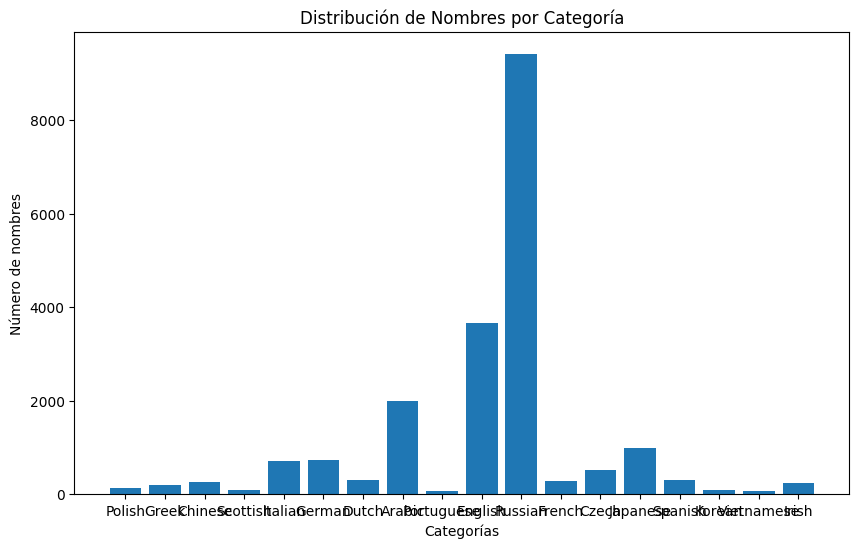

In [5]:
category_counts = []
for category in data_module.get_categories():
    count = len(data_module.category_lines[category])
    print(f"Categoría: {category}, Número de nombres: {count}")
    category_counts.append(count)


# Grafica de distribución de categorías
plt.figure(figsize=(10, 6))
plt.bar(data_module.get_categories(), category_counts)
plt.xlabel("Categorías")
plt.ylabel("Número de nombres")
plt.title("Distribución de Nombres por Categoría")
plt.show()

## Entrenamiento del modelo

Ahora entrenamos el modelo RNN usando PyTorch Lightning.

In [6]:
# Configuración del entrenamiento
CONFIG = {
    'hidden_size': 128,
    'learning_rate': 0.005,
    'n_iters': 100000,
    # 'n_iters': 2000,  # Reducido para testing
}

print("Configuración del entrenamiento:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuración del entrenamiento:
  hidden_size: 128
  learning_rate: 0.005
  n_iters: 100000


In [7]:
# Crear la instancia del modelo RNN
print("Creando modelo RNN...")

# Primero necesitamos el data module para obtener el número de categorías (output_size)
n_categories = data_module.get_n_categories()

# Crear el modelo con la configuración especificada
model = RNNClassifier(
    input_size=n_letters,
    hidden_size=CONFIG['hidden_size'],
    output_size=n_categories,
    learning_rate=CONFIG['learning_rate']
)

print(f"Modelo creado exitosamente!")
print(f"Arquitectura del modelo:")
print(f"  - Input size: {n_letters} (caracteres)")
print(f"  - Hidden size: {CONFIG['hidden_size']}")
print(f"  - Output size: {n_categories} (categorías)")
print(f"  - Learning rate: {CONFIG['learning_rate']}")

Creando modelo RNN...
Modelo creado exitosamente!
Arquitectura del modelo:
  - Input size: 57 (caracteres)
  - Hidden size: 128
  - Output size: 18 (categorías)
  - Learning rate: 0.005


In [13]:
# Inicialización del modulo lightning

callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="valid_acc") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

logger = CSVLogger(save_dir="logs/", name="crnn-2-urbansound8k")

In [14]:
#  Inicia entrenamiento

trainer = pl.Trainer(max_epochs=100000,
                    callbacks=[callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

start_time = time.time()
trainer.fit(model = model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

# Entrenar el modelo
# print("Iniciando entrenamiento...")

# trained_model, data_module_train = train_rnn(
#     model=model,
#     data_module=data_module,
#     n_iters=CONFIG['n_iters']
# )

# print("¡Entrenamiento completado!")



INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Numero de clases: 36


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ softmax    │ LogSoftmax │      0 │ train │
│ 1 │ base_model │ RNN        │ 23.9 K │ train │
│ 2 │ out        │ Linear     │  1.0 K │ train │
│ 3 │ criterion  │ NLLLoss    │      0 │ train │
└───┴────────────┴────────────┴────────┴───────┘

Trainable params: 25.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 25.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 4                                                                                           
Modules in eval mode: 0

Output()

Pesos por categoría:

Polish: 0.0438

Greek: 0.0285

Chinese: 0.0219

Scottish: 0.0569

Italian: 0.0081

German: 0.0079

Dutch: 0.0196

Arabic: 0.0028

Portuguese: 0.0813

English: 0.0016

Russian: 0.0006

French: 0.0211

Czech: 0.0112

Japanese: 0.0057

Spanish: 0.0196

Korean: 0.0632

Vietnamese: 0.0813

Irish: 0.0247

Polish: 0.0438

Greek: 0.0285

Chinese: 0.0219

Scottish: 0.0569

Italian: 0.0081

German: 0.0079

Dutch: 0.0196

Arabic: 0.0028

Portuguese: 0.0813

English: 0.0016

Russian: 0.0006

French: 0.0211

Czech: 0.0112

Japanese: 0.0057

Spanish: 0.0196

Korean: 0.0632

Vietnamese: 0.0813

Irish: 0.0247

/home/eaguayo/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.

TypeError: RNNClassifier.forward() missing 1 required positional argument: 'hidden'

## Evaluación del modelo

Evaluamos el modelo entrenado y visualizamos los resultados.

Evaluando el modelo...
Precisión: 0.7220
Número de categorías: 18


/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/train.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + categories, rotation=90)
/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/train.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + categories)


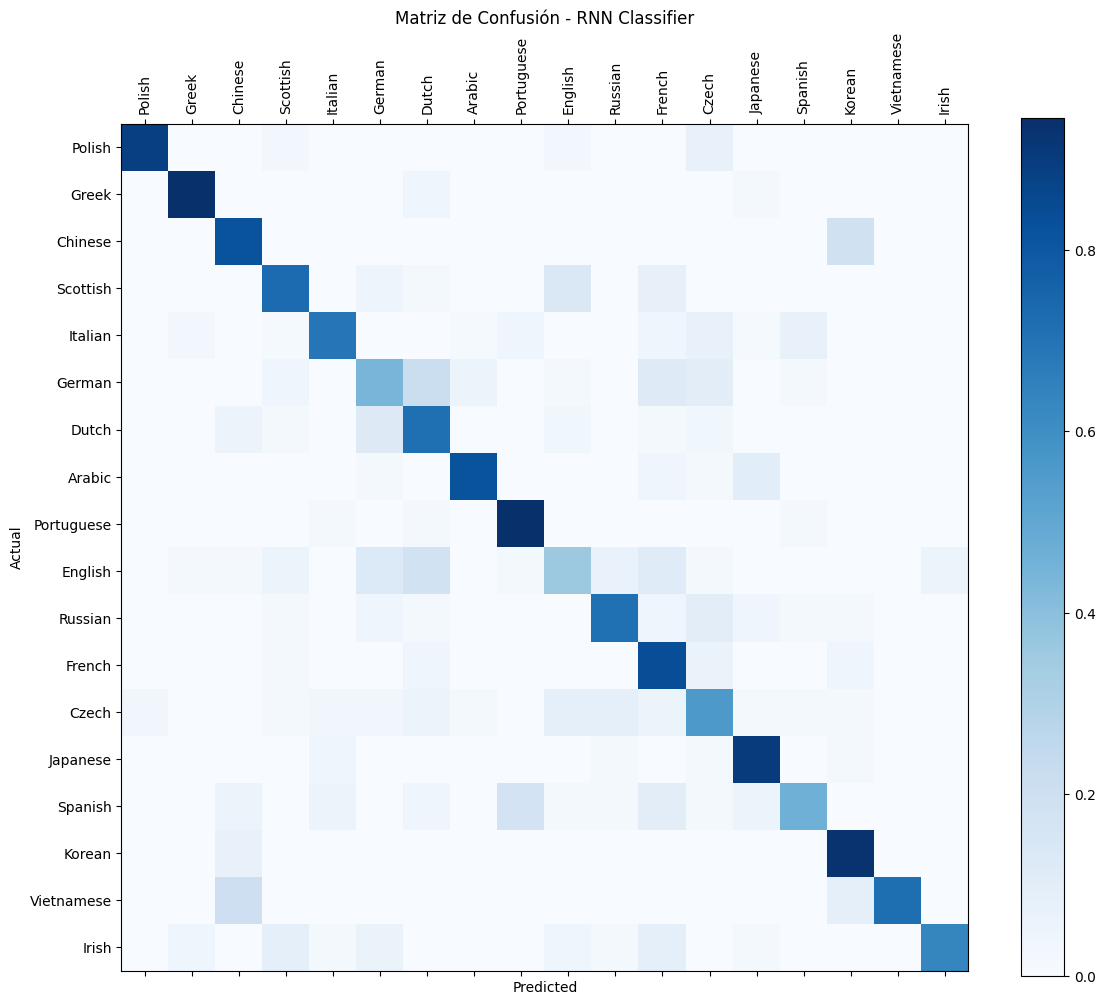

In [ ]:
# Evaluar el modelo (como en el original)
print("Evaluando el modelo...")

accuracy, confusion_matrix, categories = evaluate_model(trained_model, data_module_train, n_samples=1000)

print(f"Precisión: {accuracy:.4f}")
print(f"Número de categorías: {len(categories)}")

# Visualizar matriz de confusión
plot_confusion_matrix(confusion_matrix, categories, 'Matriz de Confusión - RNN Classifier')

## Predicciones

Probamos el modelo con algunos nombres de ejemplo.

In [ ]:
# Probar predicciones con nombres de ejemplo
test_names = ['Dovesky', 'Jackson', 'Satoshi', 'Rodriguez', 'Mueller', 'Li', 'Nakamura', 'Smith']

print("Predicciones del modelo:")
print("=" * 50)

for name in test_names:
    predictions = predict_name_origin(trained_model, name, categories, n_predictions=3)
    print()  # Línea en blanco entre predicciones

Predicciones del modelo:

> Dovesky
(-0.72) Czech
(-0.82) Russian
(-3.01) English


> Jackson
(-0.16) Scottish
(-2.07) English
(-4.76) Russian


> Satoshi
(-0.39) Japanese
(-1.69) Italian
(-2.68) Portuguese


> Rodriguez
(-0.48) Portuguese
(-1.54) Spanish
(-2.29) Dutch


> Mueller
(-0.76) Dutch
(-1.72) Czech
(-1.99) English


> Li
(-0.16) Vietnamese
(-2.36) Korean
(-3.03) Chinese


> Nakamura
(-0.01) Japanese
(-5.60) Portuguese
(-6.00) Arabic


> Smith
(-0.33) Scottish
(-2.19) German
(-2.92) Czech



## Conclusiones

La implementación con PyTorch Lightning ofrece las siguientes ventajas:

1. **Código más limpio y modular**: Separación clara de responsabilidades
2. **Mejor manejo de experimentos**: Logging automático y configuración fácil
3. **Escalabilidad**: Fácil adaptación a diferentes recursos de hardware
4. **Reproducibilidad**: Mejor control de semillas y configuraciones
5. **Funcionalidades avanzadas**: Early stopping, checkpointing, etc.
